# Stock Price Prediction using Stacked LSTM Model

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
# fix random seed for reproducibility
np.random.seed(7)

In [2]:
#Import dataset
df = pd.read_csv("big_five_stocks.csv")
df["Unnamed: 0"] = pd.to_datetime(df["Unnamed: 0"])
df["year"] = df["Unnamed: 0"].dt.year
df["month"] = df["Unnamed: 0"].dt.month
df = df.rename({"Unnamed: 0" : "date"}, axis=1, inplace=False)

# get apple stock data
apple = df[df.name == 'AAPL'].drop("name", axis=1)
apple = apple.reset_index()['close']

# scale data
sc = MinMaxScaler(feature_range = (0, 1))
apple = sc.fit_transform(np.array(apple).reshape(-1,1))
apple

array([[0.00133696],
       [0.0012507 ],
       [0.00107819],
       ...,
       [0.91620304],
       [0.91542675],
       [0.87307543]])

In [3]:
# train-test split
training_size= int(len(apple)*0.65)
test_size = len(apple)-training_size
train_data, test_data = apple[0:training_size,:],apple[training_size:len(apple),:1]
print(train_data)

[[0.00133696]
 [0.0012507 ]
 [0.00107819]
 ...
 [0.04485272]
 [0.04368827]
 [0.04351576]]


In [4]:
# create for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX),np.array(dataY)

In [5]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [7]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
98/98 [==============================] - 14s 26ms/step - loss: 2.4234e-05 - val_loss: 0.0094
Epoch 2/100
98/98 [==============================] - 2s 19ms/step - loss: 8.1267e-07 - val_loss: 0.0071
Epoch 3/100
98/98 [==============================] - 2s 19ms/step - loss: 7.7820e-07 - val_loss: 0.0053
Epoch 4/100
98/98 [==============================] - 2s 16ms/step - loss: 8.2460e-07 - val_loss: 0.0068
Epoch 5/100
98/98 [==============================] - 1s 15ms/step - loss: 8.9936e-07 - val_loss: 0.0030
Epoch 6/100
98/98 [==============================] - 2s 15ms/step - loss: 8.2004e-07 - val_loss: 0.0040
Epoch 7/100
98/98 [==============================] - 1s 15ms/step - loss: 8.4108e-07 - val_loss: 0.0028
Epoch 8/100
98/98 [==============================] - 2s 16ms/step - loss: 7.1125e-07 - val_loss: 0.0025
Epoch 9/100
98/98 [==============================] - 2s 16ms/step - loss: 7.6751e-07 - val_loss: 0.0015
Epoch 10/100
98/98 [==============================] - 2s 22ms/s

In [10]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

104/104 [==============================] - 1s 5ms/step


In [11]:
# performance
mse = mean_squared_error(y_test, test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print('RMSE: '+str(rmse))

MSE: 0.0009427858748665736
MAE: 0.01611936965527183
RMSE: 0.030704818430770334


In [12]:
train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

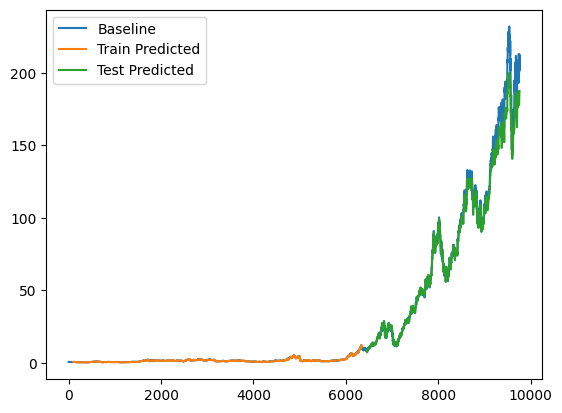

In [17]:
look_back=100
trainPredictPlot = np.empty_like(apple)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(apple)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(apple)-1, :] = test_predict
# plot baseline and predictions
plt.plot(sc.inverse_transform(apple), label='Baseline')
plt.plot(trainPredictPlot, label='Train Predicted')
plt.plot(testPredictPlot, label = 'Test Predicted')
plt.legend()
plt.show()